In [7]:
from pyomo.environ import *
from pyomo.opt import SolverFactory
import matplotlib.pyplot as plt

# Create a model
model = ConcreteModel()

# Define sets
T = range(24)  # Time periods (e.g., 24 hours)
model.T = Set(initialize=T)

# Parameters
P_max = 100  # Maximum power (kW)
E_max = 500  # Maximum energy capacity (kWh)
E_min = 0    # Minimum energy capacity (kWh)
eta_c = 0.95 # Charging efficiency
eta_d = 0.95 # Discharging efficiency
delta_t = 1  # Time step duration (hours)

# Price and frequency regulation signals (example data, replace with actual data)
C_ar = {t: 20 + 5 * (t % 2) for t in T}  # Arbitrage prices ($/kWh)
C_fr = {t: 15 for t in T}                # Frequency regulation prices ($/kWh)

# Define variables
model.Pc_ar = Var(model.T, within=NonNegativeReals, bounds=(0, P_max))  # Charging power for arbitrage
model.Pc_fr = Var(model.T, within=NonNegativeReals, bounds=(0, P_max))  # Charging power for frequency regulation
model.Pd_ar = Var(model.T, within=NonNegativeReals, bounds=(0, P_max))  # Discharging power for arbitrage
model.Pd_fr = Var(model.T, within=NonNegativeReals, bounds=(0, P_max))  # Discharging power for frequency regulation
model.E = Var(model.T, within=NonNegativeReals, bounds=(E_min, E_max))  # Energy stored
model.u_c = Var(model.T, within=Binary)  # Binary variable for charging mutual exclusivity
model.u_d = Var(model.T, within=Binary)  # Binary variable for discharging mutual exclusivity

# Objective function: Maximize revenue from arbitrage and frequency regulation
def objective_rule(model):
    return sum(model.Pd_ar[t] * C_ar[t] + model.Pd_fr[t] * C_fr[t] - model.Pc_ar[t] * C_ar[t] - model.Pc_fr[t] * C_fr[t] for t in model.T)
model.objective = Objective(rule=objective_rule, sense=maximize)

# Constraints

# Energy balance constraint
def energy_balance_rule(model, t):
    if t == 0:
        return model.E[t] == E_max / 2 + eta_c * (model.Pc_ar[t] + model.Pc_fr[t]) * delta_t - (model.Pd_ar[t] + model.Pd_fr[t]) * delta_t / eta_d
    else:
        return model.E[t] == model.E[t-1] + eta_c * (model.Pc_ar[t] + model.Pc_fr[t]) * delta_t - (model.Pd_ar[t] + model.Pd_fr[t]) * delta_t / eta_d
model.energy_balance = Constraint(model.T, rule=energy_balance_rule)

# Ending SoC constraint
def ending_soc_rule(model):
    return model.E[max(model.T)] >= model.E[0]
model.ending_soc = Constraint(rule=ending_soc_rule)

# Mutual exclusivity constraint for charging (battery cannot charge for both services simultaneously)
def mutual_exclusivity_charging_rule(model, t):
    return model.Pc_ar[t] + model.Pc_fr[t] <= P_max * model.u_c[t]
model.mutual_exclusivity_charging = Constraint(model.T, rule=mutual_exclusivity_charging_rule)

# Mutual exclusivity constraint for discharging (battery cannot discharge for both services simultaneously)
def mutual_exclusivity_discharging_rule(model, t):
    return model.Pd_ar[t] + model.Pd_fr[t] <= P_max * model.u_d[t]
model.mutual_exclusivity_discharging = Constraint(model.T, rule=mutual_exclusivity_discharging_rule)

# Prevent charging and discharging simultaneously
def prevent_simultaneous_charging_discharging_rule(model, t):
    return model.u_c[t] + model.u_d[t] <= 1
model.prevent_simultaneous_charging_discharging = Constraint(model.T, rule=prevent_simultaneous_charging_discharging_rule)

# Solve the model
solver = SolverFactory('glpk')
solver.solve(model, tee=True)

# Display results
for t in model.T:
    print(f"Time {t}: Charge Power for Arbitrage = {model.Pc_ar[t].value}, Charge Power for Frequency Regulation = {model.Pc_fr[t].value}, Discharge Power for Arbitrage = {model.Pd_ar[t].value}, Discharge Power for Frequency Regulation = {model.Pd_fr[t].value}, Energy Stored = {model.E[t].value}")

# Total revenue
print(f"Total Revenue: {model.objective()} $")


GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --write /var/folders/zm/q5z_sctj6kqfn_ln7_6g3wxh0000gn/T/tmpw5xjkr2t.glpk.raw
 --wglp /var/folders/zm/q5z_sctj6kqfn_ln7_6g3wxh0000gn/T/tmphstxw_gz.glpk.glp
 --cpxlp /var/folders/zm/q5z_sctj6kqfn_ln7_6g3wxh0000gn/T/tmp43r3kn0i.pyomo.lp
Reading problem data from '/var/folders/zm/q5z_sctj6kqfn_ln7_6g3wxh0000gn/T/tmp43r3kn0i.pyomo.lp'...
/var/folders/zm/q5z_sctj6kqfn_ln7_6g3wxh0000gn/T/tmp43r3kn0i.pyomo.lp:902: warning: lower bound of variable 'x148' redefined
/var/folders/zm/q5z_sctj6kqfn_ln7_6g3wxh0000gn/T/tmp43r3kn0i.pyomo.lp:902: warning: upper bound of variable 'x148' redefined
97 rows, 168 columns, 337 non-zeros
48 integer variables, all of which are binary
950 lines were read
Writing problem data to '/var/folders/zm/q5z_sctj6kqfn_ln7_6g3wxh0000gn/T/tmphstxw_gz.glpk.glp'...
895 lines were written
GLPK Integer Optimizer 5.0
97 rows, 168 columns, 337 non-zeros
48 integer variables, all of which are binary
Prepr

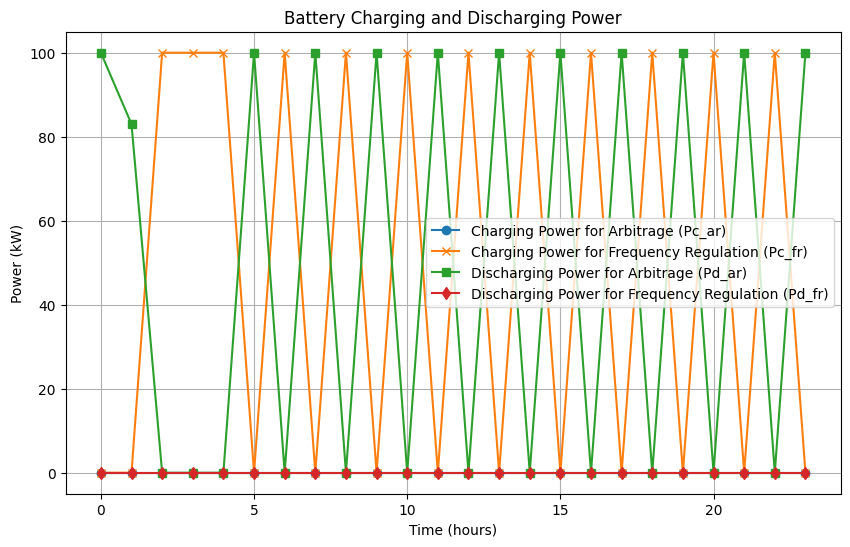

In [8]:
# Collect results
Pc_ar_values = [model.Pc_ar[t].value for t in model.T]
Pc_fr_values = [model.Pc_fr[t].value for t in model.T]
Pd_ar_values = [model.Pd_ar[t].value for t in model.T]
Pd_fr_values = [model.Pd_fr[t].value for t in model.T]
E_values = [model.E[t].value for t in model.T]

# Plot results for charging and discharging power
plt.figure(figsize=(10, 6))

plt.plot(model.T, Pc_ar_values, label='Charging Power for Arbitrage (Pc_ar)', linestyle='-', marker='o')
plt.plot(model.T, Pc_fr_values, label='Charging Power for Frequency Regulation (Pc_fr)', linestyle='-', marker='x')
plt.plot(model.T, Pd_ar_values, label='Discharging Power for Arbitrage (Pd_ar)', linestyle='-', marker='s')
plt.plot(model.T, Pd_fr_values, label='Discharging Power for Frequency Regulation (Pd_fr)', linestyle='-', marker='d')

plt.xlabel('Time (hours)')
plt.ylabel('Power (kW)')
plt.title('Battery Charging and Discharging Power')
plt.legend()
plt.grid(True)
plt.show()



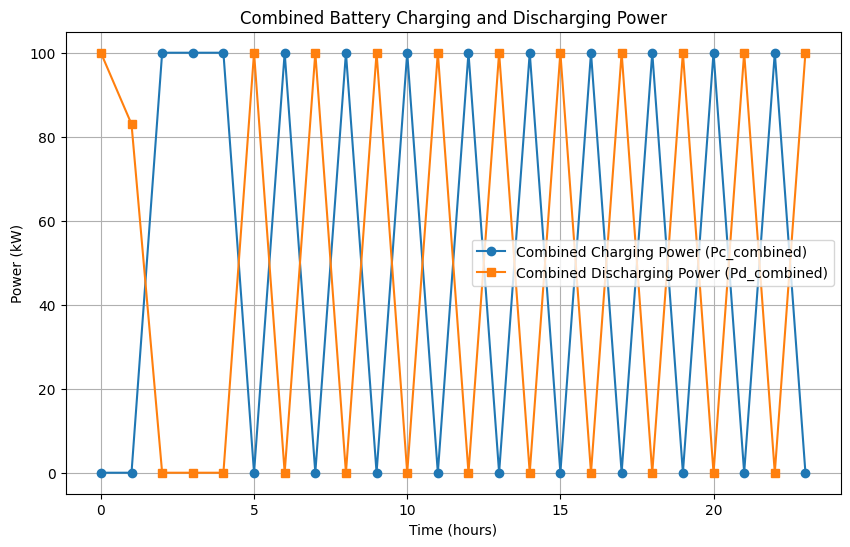

In [9]:
# Calculate combined charging and discharging
Pc_combined = [Pc_ar_values[t] + Pc_fr_values[t] for t in model.T]
Pd_combined = [Pd_ar_values[t] + Pd_fr_values[t] for t in model.T]

# Plot results for combined charging and discharging power
plt.figure(figsize=(10, 6))

plt.plot(model.T, Pc_combined, label='Combined Charging Power (Pc_combined)', linestyle='-', marker='o')
plt.plot(model.T, Pd_combined, label='Combined Discharging Power (Pd_combined)', linestyle='-', marker='s')

plt.xlabel('Time (hours)')
plt.ylabel('Power (kW)')
plt.title('Combined Battery Charging and Discharging Power')
plt.legend()
plt.grid(True)
plt.show()


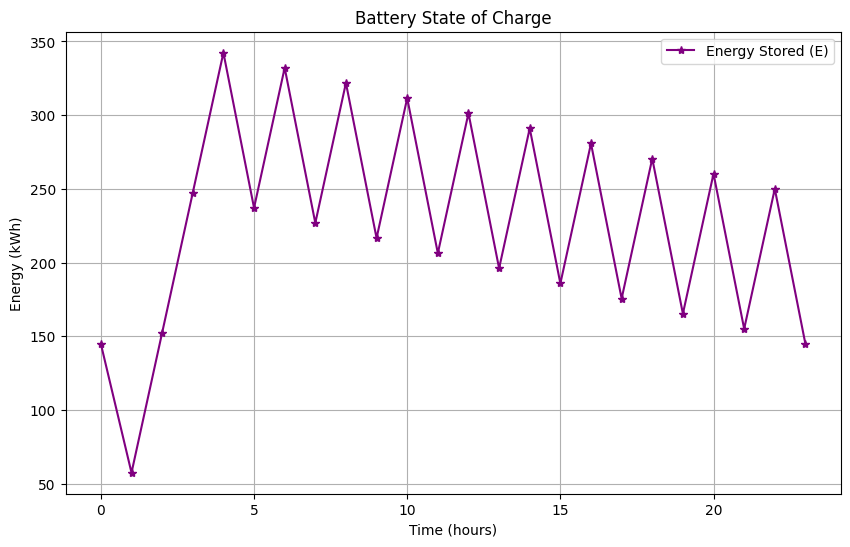

In [10]:
# Plot results for state of charge
plt.figure(figsize=(10, 6))

plt.plot(model.T, E_values, label='Energy Stored (E)', linestyle='-', marker='*', color='purple')

plt.xlabel('Time (hours)')
plt.ylabel('Energy (kWh)')
plt.title('Battery State of Charge')
plt.legend()
plt.grid(True)
plt.show()
